<a href="https://colab.research.google.com/github/hui509/titanic_analysis/blob/main/%E5%B0%88%E9%A1%8C%E5%AF%A6%E4%BD%9C%EF%BD%9C03_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F%E5%AD%98%E6%B4%BB%E9%A0%90%E6%B8%AC_%E5%84%AA%E5%8C%96%E8%B3%87%E6%96%99.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 專題實作 #03 鐵達尼號存活預測_優化資料

# **載入Titanic資料集的 `train.csv` 資料集**
（資料網址：https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv）

In [274]:
import pandas as pd
url = 'https://raw.githubusercontent.com/dsindy/kaggle-titanic/master/data/train.csv'
df = pd.read_csv(url)

# **資料概況**

1. Titanic 各欄位的定義
* PassengerId：乘客ID
* Survived：生存狀態（0=No，1=Yes）  
* Pclass：艙等 （1=1st, 2=2nd, 3=3rd）
* Name：姓名  
* Sex：性別  
* Age：年紀
* SibSp：兄弟姐妹/配偶的数量
* Parch：父母/子女的数量
* Ticket：船票號碼
* Fare：船票價格
* Cabin：艙位號碼
* Embarked：登船港口（C=Cherbourg,　Q=Queenstown,　S=Southampton）




2. 基本資訊

In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df.isnull().sum()

# **資料探索與分析 (EDA)**

**1. 初步發現：排除 Name、Sex、Ticket、Cabin、Embarked 五項非數值資料下，**
**可見「Fare」與「Survived」的正相關性最高**


In [ ]:
# 使用 Pearson 係數計算相關性
cor = df.corr()

In [ ]:
# 使用seaborn和matplotlib，視覺化呈現相關性
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(cor,annot=True,linewidth=0.5,cmap='coolwarm')
plt.title('Correlation Matrix of Titanic')
plt.show()

**2. 進階討論：低票價的乘客，存活機會較低**



In [280]:
# 定義distribution函數，以KDE圖觀察欄位與Survived之間的關係

def distribution(df,var,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(df,row=row,col=col,hue=target,aspect=3)
  facet.map(sns.kdeplot,var,fill=True)
  facet.set(xlim=(0,df[var].max()))
  facet.add_legend()

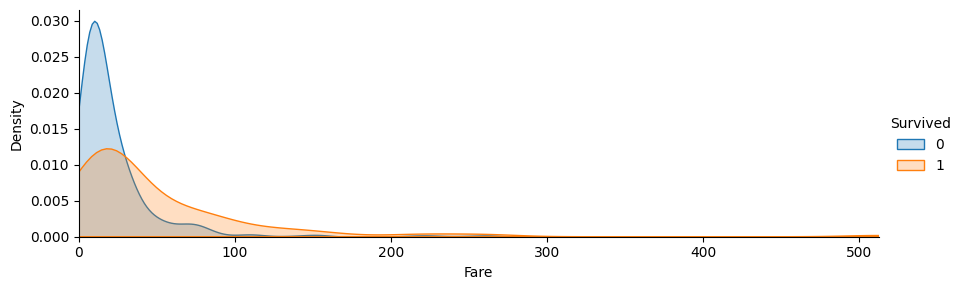

In [281]:
# 觀察Fare和Survived的關係
distribution(df,var='Fare',target='Survived')
plt.show()

**2. 其他發現：**

*   **Age 中，15歲以下的少年存活機率較高**
*   **Sex 中，女性乘客的存活機會高於男性**
*   **Pclass 中，一等艙的乘客有較高的存活機會**
*   **Embarked 中，從 Cherbourg 登船者的存活機會較高**



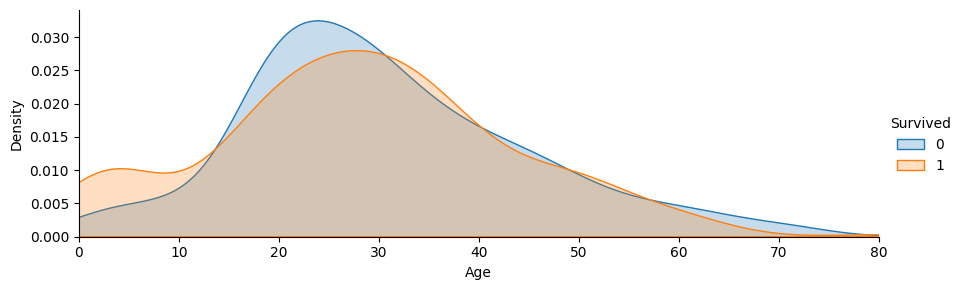

In [282]:
# 觀察Age和Survived的關係
distribution(df,var='Age',target='Survived')
plt.show()

In [283]:
# 定義categories函數，以長條圖觀察欄位與Survived之間的關係

def categories(df,cat,target,**kwargs):
  # 設定row和col參數
  row = kwargs.get('row',None)
  col = kwargs.get('col',None)

  # 使用seaborn函數製圖
  facet = sns.FacetGrid(df,row=row,col=col)
  facet.map(sns.barplot,cat,target,color='lightblue')
  facet.add_legend()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


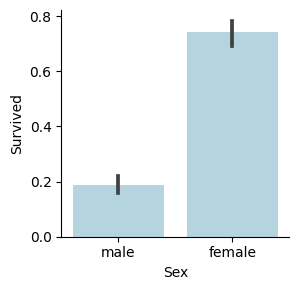

In [284]:
# 觀察Sex和Survived的關係
categories(df,cat='Sex',target='Survived')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


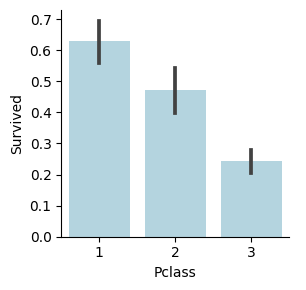

In [285]:
# 觀察Pclass和Survived的關係
categories(df,cat='Pclass',target='Survived')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


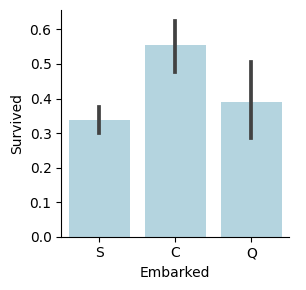

In [286]:
# 觀察Embarked和Survived的關係
categories(df,cat='Embarked',target='Survived')
plt.show()

# **資料清理與型態轉換**

1. 刪除多餘的欄位
* PassengerId：僅用以辨識乘客，無關生存
* Name：危機時期，比較不可能出現唱名救援
* Ticket：船票編號僅代表購買順序或核對資訊
* Cabin：欄位中的缺失值(687)佔全體(891)中的77%


In [287]:
titanic = df.copy()
titanic.drop(columns=['PassengerId','Name','Ticket','Cabin'],axis=1,inplace=True)

2. 轉換類別欄位：Sex、Embarked
* LabelEncoder：因欄位資料並非有序類別，故不考慮使用
* OneHotEncoder：拆分Embarked為「Embarked_C、Embarked_Q、Embarked_S」


In [288]:
# Sex直接轉換
titanic['Sex'] = titanic['Sex'].replace({'male':1,'female':0})

# Embarked使用OneHotEncoder
titanic = pd.get_dummies(titanic,columns=['Embarked'],dtype=int)

# **資料缺失值處理**

多種策略處理 Age 缺失值
* titanic_del：全部刪除
* titanic_mean：平均數填補缺
* titanic_median：中位數填補
* titanic_mode：眾數填補




In [289]:
# 全部刪除
titanic_del = titanic.copy()
titanic_del.dropna(subset=['Age'],inplace=True)

# 使用平均數填補
titanic_mean = titanic.copy()
titanic_mean['Age'].fillna(titanic_mean['Age'].mean(),inplace=True)

# 使用中位數填補
titanic_median = titanic.copy()
titanic_median['Age'].fillna(titanic_median['Age'].median(),inplace=True)

# 使用眾數填補
titanic_mode = titanic.copy()
titanic_mode['Age'].fillna(titanic_mode['Age'].mode()[0],inplace=True)


# **模型分析**

1. 評估 titanic_del 的準確度

In [ ]:
# 定義特徵欄位X、目標欄位Y，並完成訓練集資料
columns_X = set(titanic_del.columns) - {'Survived'}
columns_y = ['Survived']

train_X = titanic_del[list(columns_X)]
train_y = titanic_del[columns_y]

# 使用 Logistic Regression 模型，進行交叉驗證以評估準確度
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0,max_iter=3000)
scores_del = cross_val_score(log,train_X,train_y.values.ravel(),cv=5,scoring='accuracy')
print(scores_del)
print(scores_del.mean())

2. 評估 titanic_mean 的準確度

In [ ]:
columns_X = set(titanic_mean.columns) - {'Survived'}
columns_y = ['Survived']

train_X = titanic_mean[list(columns_X)]
train_y = titanic_mean[columns_y]

# 使用 Logistic Regression 模型，進行交叉驗證以評估準確度
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0,max_iter=3000)
scores_mean = cross_val_score(log,train_X,train_y.values.ravel(),cv=5,scoring='accuracy')
print(scores_mean)
print(scores_mean.mean())

3. 評估 titanic_median 的準確度

In [ ]:
columns_X = set(titanic_median.columns) - {'Survived'}
columns_y = ['Survived']

train_X = titanic_median[list(columns_X)]
train_y = titanic_median[columns_y]

# 使用 Logistic Regression 模型，進行交叉驗證以評估準確度
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0,max_iter=3000)
scores_median = cross_val_score(log,train_X,train_y.values.ravel(),cv=5,scoring='accuracy')
print(scores_median)
print(scores_median.mean())

4. 評估 titanic_mode 的準確度

In [ ]:
columns_X = set(titanic_mode.columns) - {'Survived'}
columns_y = ['Survived']

train_X = titanic_mode[list(columns_X)]
train_y = titanic_mode[columns_y]

# 使用 Logistic Regression 模型，進行交叉驗證以評估準確度
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log = LogisticRegression(random_state=0,max_iter=3000)
scores_mode = cross_val_score(log,train_X,train_y.values.ravel(),cv=5,scoring='accuracy')
print(scores_mode)
print(scores_mode.mean())

5. 整理與比較：以眾數處理Age的缺失值，Accuracy較高

In [294]:
scores = {'strategy':['titanic_del','titanic_mean','titanic_median','titanic_mode'],
        'accuracy':[scores_del.mean(),scores_mean.mean(),scores_median.mean(),scores_mode.mean()]}
compared = pd.DataFrame(scores)
compared.sort_values(by='accuracy',ascending=False)

,strategy,accuracy
3,titanic_mode,0.791250
2,titanic_median,0.789015
1,titanic_mean,0.789009
0,titanic_del,0.785768


# **結論：**
## **1. 資料探索與分析 (EDA)**
* Fare中，低票價的乘客，存活機會較低
* Age 中，15歲以下的少年存活機率較高
* Sex 中，女性乘客的存活機會高於男性
* Pclass 中，一等艙的乘客有較高的存活機會
* Embarked 中，從 Cherbourg 登船者的存活機會較高

## **2. 模型分析**
* 在多種缺失值處理策略中，以眾數填補的 Accuracy 約為0.79，相對較高
